# Building a micro grid system with a renewable share constraint

The energy system model was generated in yesterdays tutorial "2_tutorial_micro_grid.ipynb". It can be described as following:

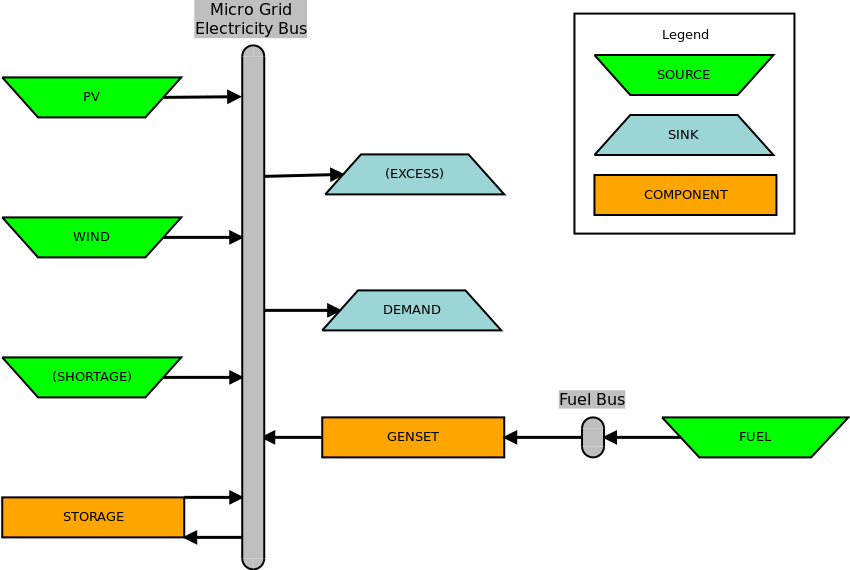

Even when adding a customized constraint to an oemof model, the initial model building is identical:

In [2]:
# importing packages
import os
import pandas as pd
from matplotlib import pyplot as plt

import oemof.solph as solph
import oemof.outputlib as outputlib
from oemof.tools import economics
from oemof.tools import logger #logger to document progress
import logging

# Define screen level of logger
logger.define_logging(screen_level=logging.INFO)

# initialize energy system
duration_hours = 5
cost_ratio_timeinterval = duration_hours/(365*24)
timeindex = pd.date_range('1/1/2017', periods=duration_hours, freq='H')
energysystem = solph.EnergySystem(timeindex=timeindex)

# loading input data
logging.info('Loading timeseries')
full_filename = '2_timeseries.csv'
timeseries = pd.read_csv(full_filename, sep=',')

# Defining fix parameters
logging.info('Defining costs')

fuel_price_kWh = 0.6/9.41 # fuel price in currency/kWh

costs = {'wind': {
             'epc': economics.annuity(capex=2000, n=20, wacc=0.05)*cost_ratio_timeinterval},
         'pv': {
             'epc': economics.annuity(capex=750, n=20, wacc=0.05)*cost_ratio_timeinterval},
         'genset': {
             'epc': economics.annuity(capex=300, n=10, wacc=0.05)*cost_ratio_timeinterval,
             'var': 0},
         'storage': {
             'epc': economics.annuity(capex=300, n=5, wacc=0.05)*cost_ratio_timeinterval,
             'var': 0}}

print('\n')

# Creating all oemof components
logging.info('DEFINITION OF OEMOF MODEL:')

logging.info('Electricity bus')
bel = solph.Bus(label='electricity_bus')
energysystem.add(bel)

logging.info('Demand, fixed timeseries')
demand_sink = solph.Sink(label='demand',
                         inputs={bel: solph.Flow(actual_value=timeseries['demand_el'],
                                                 fixed=True,
                                                 nominal_value=500)})
energysystem.add(demand_sink)

logging.info('Excess sink')
excess_sink = solph.Sink(label='excess',
                    inputs={bel: solph.Flow()})
energysystem.add(excess_sink)

logging.info('Wind plant with fixed feed-in timeseries')
wind_plant = solph.Source(label='wind',
                          outputs={
                              bel: solph.Flow(nominal_value=None,
                                              fixed=True,
                                              actual_value=timeseries['wind'],
                                              investment=solph.Investment(
                                                  ep_costs=costs['wind']['epc'], maximum=500))})
energysystem.add(wind_plant)

logging.info('PV plant with fixed feed-in timeseries')
pv_plant = solph.Source(label='pv',
                        outputs={
                            bel: solph.Flow(nominal_value=None,
                                            fixed=True,
                                            actual_value=timeseries['pv'],
                                            investment=solph.Investment(
                                                ep_costs=costs['pv']['epc'], maximum=800))})

energysystem.add(pv_plant)

logging.info('Diesel fuel bus, source and transformer')
bfuel = solph.Bus(label='fuel_bus')

fuel_source = solph.Source(label='diesel',
       outputs={
           bfuel: solph.Flow(variable_costs=fuel_price_kWh)}
       )

genset = solph.Transformer(label="genset",
                           inputs={bfuel: solph.Flow()},
                           outputs={bel: solph.Flow(
                               variable_costs=costs['genset']['var'],
                               investment=solph.Investment(
                                   ep_costs=costs['genset']['epc']))},
                           conversion_factors={bel: 0.33}
                           )

energysystem.add(bfuel, fuel_source, genset)

logging.info('Battery storage')
storage = solph.components.GenericStorage(label='storage',
                                          inputs={
                                              bel: solph.Flow()},
                                          outputs={
                                              bel: solph.Flow()},
                                          loss_rate=0.00,
                                          initial_storage_level=0.5, 
                                          invest_relation_input_capacity=1/5,
                                          invest_relation_output_capacity=1,
                                          min_storage_level = 0.2,
                                          max_storage_level = 0.8,
                                          inflow_conversion_factor=0.95,
                                          outflow_conversion_factor=0.95,
                                          investment=solph.Investment(ep_costs=costs['storage']['epc']))

energysystem.add(storage)

print('\n')
logging.info('Generating linear equation system describing defined energy system')
model = solph.Model(energysystem)

02:38:45-INFO-Path for logging: /home/mh/.oemof/log_files/oemof.log
02:38:45-INFO-Used oemof version: 0.3.1
02:38:45-INFO-Loading timeseries
02:38:45-INFO-Defining costs


02:38:45-INFO-DEFINITION OF OEMOF MODEL:
02:38:45-INFO-Electricity bus
02:38:45-INFO-Demand, fixed timeseries
02:38:45-INFO-Excess sink
02:38:45-INFO-Wind plant with fixed feed-in timeseries
02:38:45-INFO-PV plant with fixed feed-in timeseries
02:38:45-INFO-Diesel fuel bus, source and transformer
02:38:45-INFO-Battery storage


02:38:45-INFO-Generating linear equation system describing defined energy system


Instead of directly processing and solving the linear equation system with the solver, we write the generated linear equation system to a file.

In [3]:
logging.info('Saving linear equation system to file.')
model.write('./output_lp_files/2_micro_grid_inbuilt_bounds.lp', io_options={'symbolic_solver_labels': True})

02:38:45-INFO-Saving linear equation system to file.


('./output_lp_files/2_micro_grid_inbuilt_bounds.lp', 140004795674352)

Now we optimize and post-process the results:

In [4]:
logging.info('Starting oemof-optimization of capacities')
model.solve(solver='cbc', solve_kwargs={'tee': False})

logging.info('Processing results')
results = outputlib.processing.results(model)

02:38:45-INFO-Starting oemof-optimization of capacities
02:38:45-INFO-Optimization successful...
02:38:45-INFO-Processing results


In [5]:
el_bus = outputlib.views.node(results, 'electricity_bus')

logging.info('Get optimized capacities')
cap_wind = el_bus['scalars'][(('wind', 'electricity_bus'), 'invest')]
cap_pv = el_bus['scalars'][(('pv', 'electricity_bus'), 'invest')]
cap_genset = el_bus['scalars'][(('genset', 'electricity_bus'), 'invest')]

storage_bus = outputlib.views.node(results, 'storage')
cap_storage = storage_bus['scalars'][(('storage','None'), 'invest')]

logging.info('Capacities optimized: Storage (' + str(cap_storage)
             + '), Wind (' + str(cap_wind)
             + '), PV (' + str(cap_pv)
             + '), Genset (' + str(cap_genset) + ').')

02:38:45-INFO-Get optimized capacities
02:38:45-INFO-Capacities optimized: Storage (0.0), Wind (500.0), PV (0.0), Genset (126.56744).


02:38:46-INFO-Plot flows on electricity bus


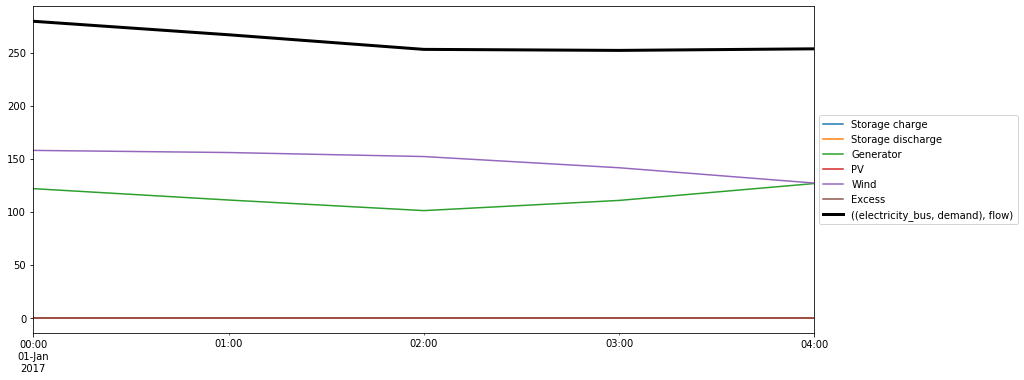

In [6]:
logging.info('Plot flows on electricity bus')
el_sequences = el_bus['sequences']

el_prod = pd.DataFrame(index=timeindex)
el_prod['Storage charge'] = - el_sequences[(('electricity_bus', 'storage'), 'flow')].clip(lower=0)
el_prod['Storage discharge'] = el_sequences[(('storage', 'electricity_bus'), 'flow')].clip(lower=0)
el_prod['Generator']=el_sequences[(('genset', 'electricity_bus'), 'flow')]
el_prod['PV']=el_sequences[(('pv', 'electricity_bus'), 'flow')]
el_prod['Wind']=el_sequences[(('wind', 'electricity_bus'), 'flow')]
el_prod['Excess']=el_sequences[(('electricity_bus', 'excess'), 'flow')]

fig, ax = plt.subplots(figsize=(14, 6))
# line plot
el_prod.plot(ax=ax)
# area plot
#el_prod.plot.area(ax=ax)
el_sequences[(('electricity_bus', 'demand'), 'flow')].plot(ax=ax, linewidth=3, c='k')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot